In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2

import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#执行第一步，连接谷歌云盘

Mounted at /content/drive


In [4]:
# 加载图像
image1 = cv2.imread('/content/drive/MyDrive/python 研究/潮州计算结果.png')
image2=cv2.imread('/content/drive/MyDrive/python 研究/潮州真实.png')

# 执行边缘检测

In [7]:
#执行边缘检测

#对第一个图像
# 转换为灰度图像
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# 边缘检测
edges = cv2.Canny(gray, 50, 100)
# 直线检测
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=8, minLineLength=5, maxLineGap=10)
  #threshold 越小，直线会判定越多   minLineLength直线最小长度，小于此长度将会被忽略 maxLineGap 同一直线上允许的最大间隔，大于此数字，将会被视为不同线段


#对第二个图
# 转换为灰度图像
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# 边缘检测
edges2 = cv2.Canny(gray2, 50, 100)

# 直线检测
lines2 = cv2.HoughLinesP(edges2, 1, np.pi / 180, threshold=5, minLineLength=5, maxLineGap=10)

# 转化为矢量线
vector_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    vector_lines.append([(x1, y1), (x2, y2)])

point_A=[]
for line in lines:
  x1, y1, x2, y2 = line[0]
  point_A.append((x1,y1))
  point_A.append((x2,y2))

In [8]:
point_B=[]
for line in lines2:
  x1, y1, x2, y2 = line[0]
  point_B.append((x1,y1))
  point_B.append((x2,y2))

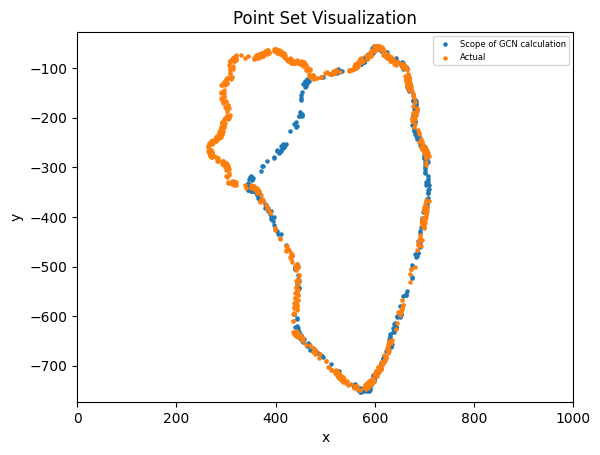

In [9]:
#将它们显示至同一个平面上
# 从点集列表A中提取x坐标和y坐标
x = [point[0] for point in point_A]
y = [-point[1] for point in point_A]



# 设置点的大小
point_size = 5  # 设置点的大小为50


# 绘制散点图
P1=plt.scatter(x, y, s=point_size,label="Scope of GCN calculation")




# 从点集列表B中提取x坐标和y坐标
x1 = [point[0] for point in point_B]
y1 = [-point[1] for point in point_B]

# 设置点的大小
point_size = 5  # 设置点的大小为50


# 绘制散点图
P2=plt.scatter(x1, y1, s=point_size,label="Actual")

plt.legend(loc='upper right',fontsize=6) # 添加图例

plt.xlabel('x')
plt.ylabel('y')
plt.title('Point Set Visualization')

# 设置X轴和Y轴比例为1:1

plt.axis('equal')
plt.axis([00,1000,-1800,1000])


# 显示图形
plt.show()

# 执行豪斯多夫距离相似率

In [10]:
#计算机判断的街区轮廓的点集
print(point_A[0])
print(len(point_A))
#实际的城市街区轮廓点集
print(point_B[1])
print(len(point_B))

(443, 619)
342
(372, 76)
686


In [11]:
A=point_A
B=point_B

In [12]:
#定义豪斯多夫距离相似率
import math
from statistics import median
def similarity(A, B):
  min_dists_a = []
  for a in A:
    # 计算每个点a到点集B的最近距离
    min_dist = min([math.hypot(a[0]-b[0], a[1]-b[1]) for b in B])
    min_dists_a.append(min_dist)

  min_dists_b = []
  for b in B:
    # 计算每个点b到点集A的最近距离
    min_dist = min([math.hypot(a[0]-b[0], a[1]-b[1]) for a in A])
    min_dists_b.append(min_dist)

  diff = sum(min_dists_a + min_dists_b) / len(A + B)
  #diff = ( sum(min_dists_a)/len(A) + sum(min_dists_b)/len(B) )/2
  #diff=max( sum(min_dists_a)/len(A), sum(min_dists_b)/len(B))

  # 计算点集内部距离
  inner_a = inner_dist(A) #此处的函数由下个代码块定义
  inner_b = inner_dist(B)

  inner_diff = (inner_a + inner_b) / 2

  ratio = diff / inner_diff# 在这里，用inner_diff 和  inner_b  意义有略微差别  请确保 inner_b  是真实轮廓

  similarity = max(1 - ratio, 0)

  return similarity,ratio,diff,inner_diff

  return similarity,ratio,diff,inner_diff
#similarity：豪斯多夫距离轮廓准确度，inner_diff：两个点集内各点的平均距离的平均,diff

In [13]:
# 全计算内部平均距离的函数
def inner_dist(points):

  distances = []

  for p1 in points:
    p1_dists = []
    for p2 in points:
      if p1 != p2:
        dist = math.hypot(p1[0] - p2[0], p1[1] - p2[1])
        p1_dists.append(dist)

    p1_mean_dist = sum(p1_dists) / (len(points) - 1)
    distances.append(p1_mean_dist)

  total_dist = sum(distances)

  return total_dist / len(points)

In [14]:
Hsduofu_accuracy=similarity(A,B)
print(Hsduofu_accuracy)

(0.9120774855847439, 0.08792251441525607, 28.697118600969308, 326.39101363085973)


# 遗传算法计算中心点

In [15]:
import numpy as np
from scipy.spatial import distance

def calculate_fitness(population, point_set):
    # 计算每个个体的适应度（即平均距离的倒数）
    fitness = []
    for individual in population:
        total_distance = sum(distance.euclidean(individual, point) for point in point_set)
        avg_distance = total_distance / len(point_set)
        fitness.append(1 / avg_distance)
    return fitness

def generate_population(size, bounds):
    # 生成初始种群
    population = []
    for _ in range(size):
        individual = np.random.uniform(bounds[0], bounds[1], size=2)
        population.append(individual)
    return population

def crossover(parents, offspring_size):
    # 交叉繁殖生成后代
    offspring = []
    for _ in range(offspring_size):
        index1, index2 = np.random.randint(len(parents), size=2)
        parent1, parent2 = parents[index1], parents[index2]
        offspring.append((parent1 + parent2) / 2)
    return offspring

def mutate(offspring, mutation_rate, bounds):
    # 突变操作
    for individual in offspring:
        if np.random.rand() < mutation_rate:
            individual += np.random.uniform(bounds[0], bounds[1], size=2)
    return offspring

def genetic_algorithm(point_set, population_size=100, generations=300, mutation_rate=0.2, bounds=(0, 1750)):
    population = generate_population(population_size, bounds)

    for _ in range(generations):
        fitness = calculate_fitness(population, point_set)
        parents = [population[i] for i in np.argsort(fitness)[-int(population_size / 2):]]
        offspring = crossover(parents, population_size - len(parents))
        offspring = mutate(offspring, mutation_rate, bounds)
        population = parents + offspring

    best_individual = population[np.argmax(calculate_fitness(population, point_set))]
    return best_individual

In [17]:
#计算最佳点
point_set = point_A
best_point = genetic_algorithm(point_set)
print("最佳点：", best_point)

最佳点： [554.28320435 373.29787826]


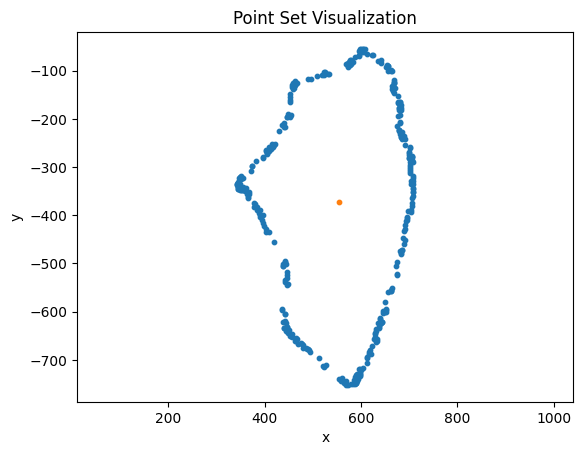

In [18]:
# 从点集列表A中提取x坐标和y坐标
x = [point[0] for point in point_A]
y = [-point[1] for point in point_A]

X=best_point[0]
Y=-best_point[1]

# 设置点的大小
point_size = 10  # 设置点的大小为50


# 绘制散点图

kp1=plt.scatter(x, y, s=point_size)

kp2=plt.scatter(X, Y, s=point_size)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Point Set Visualization')
# 设置X轴和Y轴比例为1:1
plt.axis('equal')



# 显示图形
plt.show()

In [19]:
#对第二个图
point_set_B = point_B
best_pointB = genetic_algorithm(point_set_B)
print("最佳点：", best_pointB)

最佳点： [471.04162381 265.2111974 ]


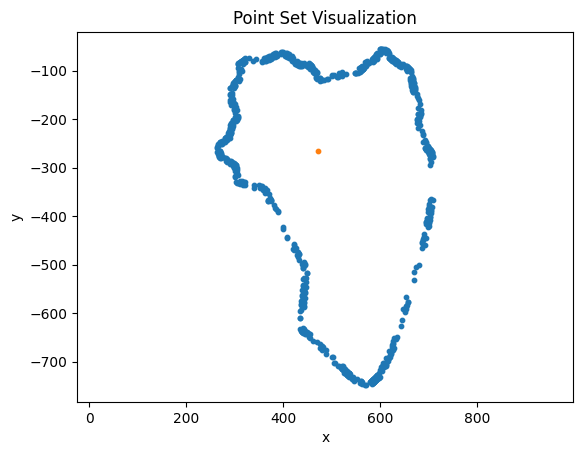

In [20]:
# 从点集列表A中提取x坐标和y坐标
x = [point[0] for point in point_B]
y = [-point[1] for point in point_B]

X=best_pointB[0]
Y=-best_pointB[1]

# 设置点的大小
point_size = 10  # 设置点的大小为50

# 绘制散点图
kp1_2=plt.scatter(x, y, s=point_size)

kp2_2=plt.scatter(X, Y, s=point_size)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Point Set Visualization')
# 设置X轴和Y轴比例为1:1
plt.axis('equal')

# 显示图形
plt.show()

# 转化为极坐标系

In [21]:
def visualize_polar(point_set, center_point):
    # 将点集A中的每个点转换为极坐标
    polar_coords = []
    for point in point_set:
        dx = point[0] - center_point[0]
        dy = point[1] - center_point[1]
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        polar_coords.append((r, theta))

    # 绘制极坐标图
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.scatter([coord[1] for coord in polar_coords], [coord[0] for coord in polar_coords])

    # 设置极坐标轴的样式
    ax.spines['polar'].set_visible(False)  # 隐藏极坐标轴线
    ax.set_yticklabels([])  # 关闭半径刻度

    # 设置标题
    ax.set_title("Polar Visualization", pad=20)

    # 显示图形
    plt.show()

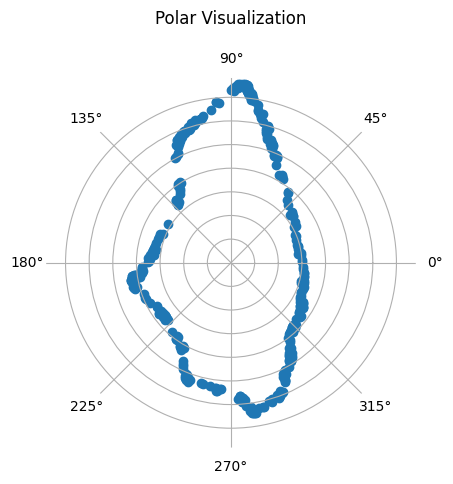

In [22]:
#第一个图
point_set = point_A # 点集A
center_point = best_point  # 点C，极坐标的原点
visualize_polar(point_set, center_point)

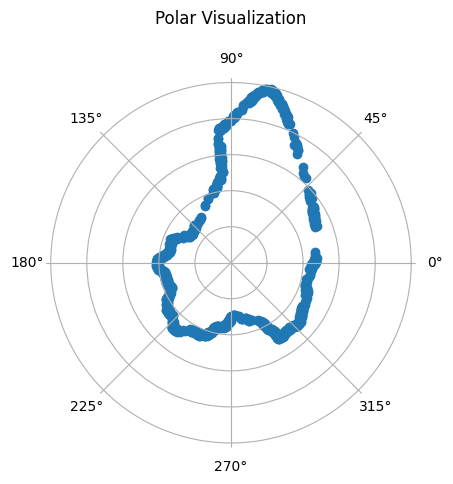

In [23]:
# 第二个图
point_setB = point_B # 点集B
center_pointB = best_pointB  # 点C，极坐标的原点
visualize_polar(point_setB, center_pointB)

**将直角坐标转化为极坐标**

In [25]:


polar_coordsA = []
for point in point_set:

        dx = point[0] - center_point[0]
        dy = point[1] - center_point[1]
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        degrees = np.degrees(theta)#此时转化为角度制
        polar_coordsA.append((r, degrees))


polar_coordsB = []
for point in point_setB:

        dx = point[0] - center_pointB[0]
        dy = point[1] - center_pointB[1]
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        degrees = np.degrees(theta)#此时转化为角度制
        polar_coordsB.append((r, degrees))

**将点集按角度从小到大排序，最小为-π，最大为π将点集按角度从小到大排序，最小为-π，最大为π**

In [26]:
polar_coordsA_1 = sorted(polar_coordsA, key=lambda point: point[1])

polar_coordsB_1 = sorted(polar_coordsB, key=lambda point: point[1])

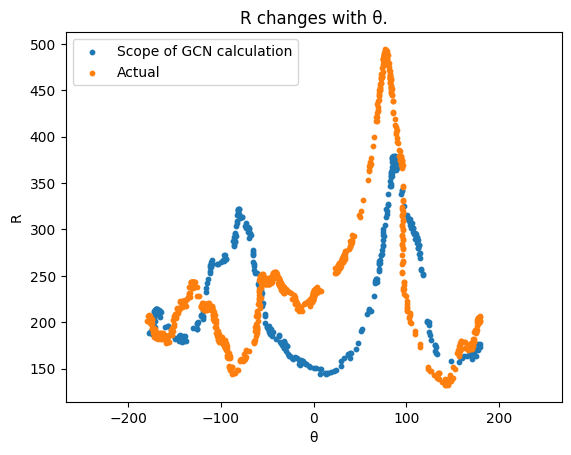

In [27]:
# 从点集列表A中提取角度和边长，注意U,V的顺序
u = [point[0] for point in polar_coordsA_1]
v = [point[1] for point in polar_coordsA_1]

u_B=[point[0] for point in polar_coordsB_1]
v_B=[point[1] for point in polar_coordsB_1]

# 设置点的大小
point_size = 10  # 设置点的大小为50


# 绘制散点图

P1=plt.scatter(v, u, s=point_size,label="Scope of GCN calculation")
P2=plt.scatter(v_B, u_B, s=point_size,label="Actual")

plt.legend() # 添加图例

plt.xlabel('θ')
plt.ylabel('R')
plt.title('R changes with θ.')
# 设置X轴和Y轴比例为1:1
plt.axis('equal')



# 显示图形
plt.show()